# Dual Polarization IQ Modulator

This example will show how to build and route a dual polarization IQ modulator using the [SiEPIC OpenEBL](https://siepic.ca/openebl/) photonics platform.

In [1]:
import numpy as np
import photonforge as pf
import siepic_forge as siepic
from photonforge.live_viewer import LiveViewer

viewer = LiveViewer()

Starting live viewer at http://localhost:5001


Address already in use
Port 5001 is in use by another program. Either identify and stop that program, or start the server with a different port.


We start by setting a few default parameters in the global [configuration](../config.rst).

In [2]:
pf.config.svg_labels = False

tech = siepic.ebeam()
pf.config.default_technology = tech

port_spec = tech.ports["TE_1550_500"]
pf.config.default_kwargs["port_spec"] = port_spec

pf.config.default_kwargs["radius"] = 20
pf.config.default_kwargs["euler_fraction"] = 0.5

The modulator output includes both TE and TM waveguide polarizations, so we need to create an additional [port specification](../guides/Ports.ipynb) with support for both:

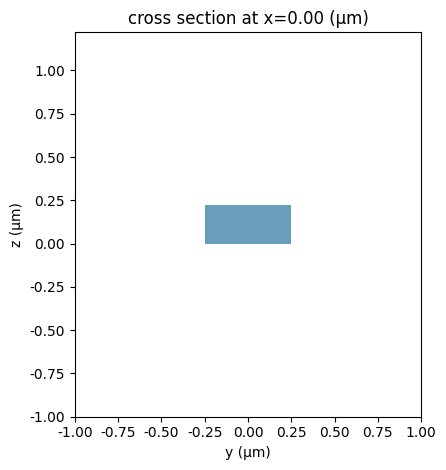

In [3]:
dual_mode_spec = port_spec.copy()
dual_mode_spec.num_modes = 2  # Use both modes

# Add back to the default technology to use it more easily later
tech.add_port("TE-TM_1550_500", dual_mode_spec)

_ = pf.tidy3d_plot(dual_mode_spec)

The modulator will use a co-planar waveguide (CPW) for the RF signal, so we also need to create an appropriate specification for that.
We will use the [cpw_spec](../_autosummary/photonforge.cpw_spec.rst) utility to generate the specification with default parameters.

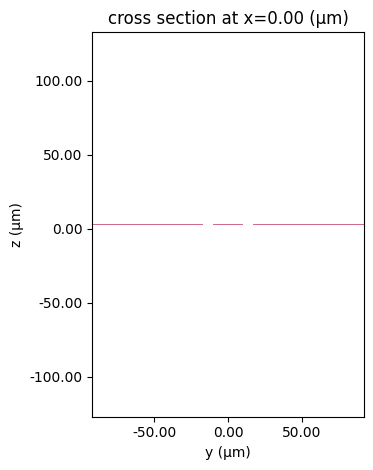

In [4]:
cpw_spec = pf.cpw_spec("M2_router", signal_width=20, gap=7, ground_width=75)
tech.add_port("CPW", cpw_spec)

_ = pf.tidy3d_plot(cpw_spec)

## MZM design

The main component in the modulator is a phase shifter.
We create this, and all other components, as a [parametric component](../guides/Custom_Parametric_Components.ipynb), so that we can use caching, updates and store parametric arguments for free, in case we need them later. 

In [5]:
@pf.parametric_component
def phase_shifter(
    *,
    length=3000,
    rib_width=7,
    taper_length=10,
    i_width=0.15,
    p_width=1.75,
    pp_width=1.7,
    p_contact=1.0,
    pad_size=100,
    pad_distance=200,
    pad_separation=150,
):
    strip = pf.config.default_kwargs["port_spec"]

    rib = strip.copy()
    rib.description = "Phase shifter internal"
    rib.width = rib_width - 2 * pf.config.tolerance
    rib.path_profiles = rib.path_profiles + [(rib_width, 0, "Si slab")]

    taper = pf.parametric.transition(
        port_spec1=strip, port_spec2=rib, length=taper_length
    )

    straight = pf.parametric.straight(port_spec=rib, length=length)

    c = pf.Component()

    taper_in = c.add_reference(taper)
    ps = c.add_reference(straight).connect("P0", taper_in["P1"])
    taper_out = c.add_reference(taper).connect("P1", ps["P1"])

    c.add_port([taper_in["P0"], taper_out["P0"]])

    doping_regions = [
        # start y, width, layer
        (rib_width / 2 - p_contact, p_contact, "Si"),
        (i_width / 2, p_width, "Si N"),
        (i_width / 2 + p_width, pp_width, "Si N++"),
    ]
    for y, width, layer in doping_regions:
        straight.add(
            layer,
            pf.Rectangle(corner1=(0, y), size=(length, width)),
            pf.Rectangle(corner2=(length, -y), size=(length, width)),
        )

    # Add CPW
    w1, off1, _ = cpw_spec.path_profiles["gnd1"]
    w0, off0, _ = cpw_spec.path_profiles["signal"]
    offset = (w0 / 2 + off1 - w1 / 2) / 2
    cpw = pf.Reference(
        pf.parametric.straight(port_spec=cpw_spec, length=length + 2 * taper_length),
        (0, -offset),
    )
    c.add(cpw)

    # Add terminals
    c.add_terminal(
        {
            f"{name}:{side}": pf.Terminal(
                "M2_router",
                pf.Rectangle(center=(x, y - offset), size=(pad_size, pad_size)),
            )
            for x, side in [
                (-pad_distance - pad_size / 2, "in"),
                (length + 2 * taper_length + pad_distance + pad_size / 2, "out"),
            ]
            for y, name in [
                (-pad_separation, "gnd0"),
                (0, "signal"),
                (pad_separation, "gnd1"),
            ]
        }
    )

    for p, side in [("E0", "in"), ("E1", "out")]:
        for name in ("gnd0", "signal", "gnd1"):
            c.add(
                pf.parametric.route_taper(
                    terminal1=c[f"{name}:{side}"], terminal2=cpw[p].terminals(name)
                )
            )

    # Add integrated termination
    c.add(
        "M1_heater",
        pf.envelope([c["gnd0:in"].structure, c["gnd1:in"].structure], use_box=True),
    )

    c.add_model(pf.CircuitModel(), "Circuit")

    return c


ps = phase_shifter()
viewer(ps)

Besides the phase shifter, we will also need a splitter and a thermal tuning element.
For the splitter, the PDK already includes a Y junction that we can use directly:

In [6]:
splitter = siepic.component("ebeam_y_1550")
splitter

And for the thermal tuning element, we can create a straight waveguide section with a heater and proper [terminals](../guides/Electrical_Ports.ipynb) to access them.

In [7]:
@pf.parametric_component
def heated_waveguide(*, length=200, heater_width=3, pad_size=20, pad_distance=5):
    c = pf.Component()

    ref = c.add_reference(pf.parametric.straight(length=length))
    c.add_port([ref["P0"], ref["P1"]])

    heater = pf.Path((-pad_distance - pad_size, 0), pad_size)
    heater.segment((-pad_distance, 0))
    heater.segment((0, 0), heater_width)
    heater.segment((length, 0))
    heater.segment((length + pad_distance, 0), pad_size)
    heater.segment((length + pad_distance + pad_size, 0))

    c.add("M1_heater", heater)

    pad0 = pf.Terminal(
        "M2_router",
        pf.Rectangle(
            center=(-pad_distance - pad_size / 2, 0), size=(pad_size, pad_size)
        ),
    )
    pad1 = pf.Terminal(
        "M2_router",
        pf.Rectangle(
            center=(length + pad_distance + pad_size / 2, 0), size=(pad_size, pad_size)
        ),
    )

    c.add_terminal([pad0, pad1], add_structure=True)

    c.add_model(pf.CircuitModel(), "Circuit")

    return c


heater = heated_waveguide()
viewer(heater)

We use each created component to construct a Mach-Zehnder modulator with thermal tuning on both arms.
We make sure to route the ground terminals and add the remaining ones to be routed later.
In particular, the 2 sets of GSG pads from each phase shifter are joined together to form a GSGSG pad.

In [8]:
@pf.parametric_component
def create_mzm(*, heater_gap=150):
    c = pf.Component()

    arm_bot = c.add_reference(ps)
    arm_top = c.add_reference(ps)

    offset = arm_bot["gnd1:in"].center() - arm_top["gnd0:in"].center()

    arm_bot.translate(-offset / 2)
    arm_top.translate(offset / 2)

    heater_bot = c.add_reference(heater).translate(-offset / 2)
    heater_top = c.add_reference(heater).translate(offset / 2)
    heater_bot.x_max = arm_bot.x_min - heater_gap
    heater_top.x_max = arm_top.x_min - heater_gap

    c.add(
        pf.parametric.route(port1=(heater_bot, "P1"), port2=(arm_bot, "P0")),
        pf.parametric.route(port1=(heater_top, "P1"), port2=(arm_top, "P0")),
    )

    radius = pf.config.default_kwargs["radius"]

    y_in = c.add_reference(splitter)
    y_out = c.add_reference(splitter).rotate(180)
    y_in.x_max = heater_bot["P0"].center[0] - 2 * radius
    y_out.x_min = arm_bot["P1"].center[0] + 2 * radius

    c.add(
        pf.parametric.route(port1=(y_in, "P1"), port2=(heater_bot, "P0")),
        pf.parametric.route(port1=(y_in, "P2"), port2=(heater_top, "P0")),
        pf.parametric.route(port1=(arm_bot, "P1"), port2=(y_out, "P2")),
        pf.parametric.route(port1=(arm_top, "P1"), port2=(y_out, "P1")),
    )

    c.add(
        pf.parametric.route_manhattan(
            terminal1=(heater_bot, "T1"), terminal2=(arm_bot, "gnd0:in"), direction1="y"
        ),
        pf.parametric.route_manhattan(
            terminal1=(heater_top, "T1"), terminal2=(arm_top, "gnd1:in"), direction1="y"
        ),
    )

    c.add_port([y_in["P0"], y_out["P0"]])
    c.add_terminal(
        {
            "gnd0": arm_bot["gnd0:out"],
            "sig0": arm_bot["signal:out"],
            "gnd1": arm_bot["gnd1:out"],
            "sig1": arm_top["signal:out"],
            "gnd2": arm_top["gnd1:out"],
            "T0": heater_bot["T0"],
            "T1": heater_top["T0"],
            "gnd:heater": arm_bot["gnd1:in"],
        }
    )

    c.add_model(pf.CircuitModel(), "Circuit")

    return c


mzm = create_mzm()
viewer(mzm)

## Dual polarization modulator

The full modulator will use 2 of those modulator branches, one for each polarization.
Their output signals must be combined with a polarization splitter and rotator (PSR), similar to the one designed in [another example notebook](Polarization_Splitter_Rotator.ipynb).
We use the same design here for convenience:

In [9]:
@pf.parametric_component
def polarization_splitter_rotator(
    *,
    rotator_length=30,
    mid_taper_length=5,
    splitter_length=42.4,
    taper_length=10,
    rotator_width=1.2,
    taper_width=0.1,
    coupler_width1=0.9,
    coupler_width2=0.75,
    splitter_width1=0.2,
    gap=0.15,
    s_factor=6,
):
    component = pf.Component()

    core_width, _ = port_spec.path_profile_for("Si")
    output_separation = port_spec.width
    s_bend_length = s_factor * output_separation
    splitter_width2 = coupler_width1 + splitter_width1 - coupler_width2
    if splitter_width2 <= 0:
        raise ValueError("Invalid input")

    p0 = (0, 0)
    p1 = (
        rotator_length
        + mid_taper_length
        + splitter_length
        + s_bend_length
        + taper_length,
        -output_separation,
    )
    p2 = (
        rotator_length
        + mid_taper_length
        + splitter_length
        + s_bend_length
        + taper_length,
        gap + 0.5 * (coupler_width2 + splitter_width2),
    )
    tapers = [
        pf.Path(p0, core_width).segment((rotator_length, 0), taper_width),
        pf.Path(p1, core_width).segment((-taper_length, 0), taper_width, relative=True),
        pf.Path(p2, core_width).segment((-taper_length, 0), taper_width, relative=True),
    ]

    main_path = (
        pf.Path((0, 0), core_width)
        .segment((rotator_length, 0), rotator_width)
        .segment((mid_taper_length, 0), coupler_width1, relative=True)
        .segment((splitter_length, 0), coupler_width2, relative=True)
        .s_bend((s_bend_length, -output_separation), euler_fraction=0.5, relative=True)
        .segment((taper_length, 0), core_width, relative=True)
    )

    coupled_path = (
        pf.Path(p2, core_width)
        .segment((-taper_length, 0), splitter_width2, relative=True)
        .segment((-s_bend_length, 0), relative=True)
        .segment((-splitter_length, 0), splitter_width1, relative=True)
    )
    component.add("Si", *tapers, "Si slab", main_path, coupled_path)

    component.add_port(
        [
            pf.Port(p0, 0, "TE-TM_1550_500"),
            pf.Port(p1, 180, "TE_1550_500"),
            pf.Port(p2, 180, "TE_1550_500"),
        ]
    )

    component.add_model(pf.Tidy3DModel(), "Tidy3D")

    return component


psr = polarization_splitter_rotator()
viewer(psr)

We add yet another heater section and splitter to build the input section of the modulator.
The output, as mentioned before, will be joined through the PSR.

In [10]:
@pf.parametric_component
def create_dual_pol_mod(*, cpw_pad_separation=500):
    c = pf.Component()

    arm_bot = c.add_reference(mzm)
    arm_top = c.add_reference(mzm)

    offset = mzm.size()[1] + cpw_pad_separation

    arm_bot.translate((0, -offset / 2))
    arm_top.translate((0, offset / 2))

    heater_top = c.add_reference(heater).connect("P1", arm_top["P0"])

    radius = pf.config.default_kwargs["radius"]

    y_in = c.add_reference(splitter)
    y_in.x_max = heater_top["P0"].center[0] - 2 * radius

    psr_out = c.add_reference(psr).rotate(180)
    psr_out.x_min = arm_bot["P1"].center[0] + 2 * radius

    c.add(
        pf.parametric.route(port1=(y_in, "P1"), port2=(arm_bot, "P0")),
        pf.parametric.route(port1=(y_in, "P2"), port2=(heater_top, "P0")),
        pf.parametric.route(port1=(arm_bot, "P1"), port2=(psr_out, "P2")),
        pf.parametric.route(port1=(arm_top, "P1"), port2=(psr_out, "P1")),
    )

    c.add(
        pf.parametric.route_manhattan(
            terminal1=(heater_top, "T1"), terminal2=(arm_top, "gnd:heater")
        )
    )

    c.add_port([y_in["P0"], psr_out["P0"]])
    c.add_terminal(
        {
            f"{k}:bot": v[0]
            for k, v in arm_bot.get_terminals().items()
            if "heater" not in k
        }
    )
    c.add_terminal(
        {
            f"{k}:top": v[0]
            for k, v in arm_top.get_terminals().items()
            if "heater" not in k
        }
    )
    c.add_terminal(heater_top["T0"], "T2:top")

    c.add_model(pf.CircuitModel(), "Circuit")

    return c


dpm = create_dual_pol_mod()
viewer(dpm)

## Full chip layout

With the main device ready, we only need to add the input and output edge couplers, electrical pads and alignment marks to finalize the chip.

The edge coupler design is based on [another example](Edge_Coupler.ipynb).
The only difference here is that we make sure to align the waveguide port to one of the coordinate axis, so that we avoid any warnings about angled ports possibly leading to discontinuities in waveguides.
We also add the option for the coupler to be used for TE only (chip input) or TE and TM modes (chip output).

In [11]:
@pf.parametric_component
def angled_edge_coupler(
    *,
    width_tip=0.15,
    length_taper=100,
    angle_taper=7,
    waist_radius=1.25,
    fiber_distance=3.0,
    angle_fiber=10.2,
    trench_size=(150, 10),
    dual_polarization=True,
):
    c = pf.Component()

    core_width, _ = port_spec.path_profile_for("Si")

    v_taper = np.array(
        (-np.sin(angle_taper / 180 * np.pi), np.cos(angle_taper / 180 * np.pi))
    )
    v_fiber = np.array(
        (-np.sin(angle_fiber / 180 * np.pi), np.cos(angle_fiber / 180 * np.pi))
    )

    taper_core = pf.Path(-waist_radius * v_taper, width_tip)
    taper_core.segment((0, 0)).segment(length_taper * v_taper, core_width)
    # Finish the waveguide aligned to the y axis to avoid discontinuities at the port
    taper_core.turn(-angle_taper).segment((0, port_spec.width), relative=True)

    c.add(
        "Si",
        taper_core,
        "Deep Trench",
        pf.Rectangle(center=(0, -trench_size[1] / 2), size=trench_size),
    )

    endpoint, *_ = taper_core.at(taper_core.size)
    port_waveguide = pf.Port(
        endpoint, -90, "TE-TM_1550_500" if dual_polarization else port_spec
    )
    c.add_port(port_waveguide)

    fiber_center = -fiber_distance * v_fiber
    port_fiber_te = pf.GaussianPort(
        center=(
            fiber_center[0],
            fiber_center[1],
            tech.parametric_kwargs["si_thickness"] / 2,
        ),
        input_vector=(v_fiber[0], v_fiber[1], 0),
        waist_radius=waist_radius,
        polarization_angle=0,
    )
    c.add_port(port_fiber_te)

    if dual_polarization:
        port_fiber_tm = port_fiber_te.copy(deep=True)
        port_fiber_tm.polarization_angle = 90
        c.add_port(port_fiber_tm)

    c.add_model(pf.Tidy3DModel(), "Tidy3D")

    return c


edge_coupler_te = angled_edge_coupler(dual_polarization=False)
edge_coupler_dual = angled_edge_coupler()
viewer(edge_coupler_dual)

The alignment mark will be a simple cross with a window and [Vernier scales](../_autosummary/photonforge.stencil.vernier_scale.rst) on four sides.

In [12]:
def alignment_mark(
    cross_size=100,
    marker_width=1,
    vernier_divider=5,
    layer1="Si",
    layer2="M2_router",
):
    c = pf.Component()

    # Make the cross
    c.add(
        layer1,
        pf.stencil.cross(cross_size / 2, marker_width),
        pf.Rectangle((0, 0), (cross_size / 8, cross_size / 8)),
        pf.Rectangle((0, 0), (-cross_size / 8, -cross_size / 8)),
    )

    ruler_unit = cross_size / (2 * vernier_divider)
    marker_length = cross_size / 16
    r1, r2 = pf.stencil.vernier_scale(
        ruler_unit, marker_length, marker_width, divider=vernier_divider
    )
    ruler = pf.Component(f"VERNIER_{1000 * ruler_unit / vernier_divider:g}NM")
    ruler.add(layer1, *r1, *[r.copy().mirror((0, 1)) for r in r1[1:]])
    ruler.add(layer2, *r2, *[r.copy().mirror((0, 1)) for r in r2[1:]])

    d = cross_size / 2 + marker_length
    c.add_reference(ruler).translate((0, -d))
    c.add_reference(ruler).translate((0, -d)).rotate(90)
    c.add_reference(ruler).translate((0, -d)).rotate(180)
    c.add_reference(ruler).translate((0, -d)).rotate(270)

    return c


mark = alignment_mark()
viewer(mark)

Putting it all together, the full chip can be built and properly routed.

In [13]:
@pf.parametric_component(name_prefix="MAIN")
def create_main(*, coupler_spacing=127):
    c = pf.Component()

    in_coupler = c.add_reference(edge_coupler_te)
    out_coupler = c.add_reference(edge_coupler_dual).translate((coupler_spacing, 0))
    loopback = pf.Reference(
        edge_coupler_dual,
        (2 * coupler_spacing, 0),
        columns=2,
        spacing=(coupler_spacing, 0),
    )
    c.add(loopback)

    align_pad = 1.5 * mark.size()[0]
    radius = pf.config.default_kwargs["radius"]

    mod_ref = c.add_reference(dpm).translate(
        (in_coupler["P0"].center[0] - dpm["P0"].center[0] + radius, 0)
    )
    mod_ref.y_min = 2 * align_pad

    c.add(
        pf.parametric.route(port1=(in_coupler, "P0"), port2=(mod_ref, "P0")),
        pf.parametric.route(
            port1=(out_coupler, "P0"),
            port2=(mod_ref, "P1"),
            waypoints=[(mod_ref["P1"].center[0], mod_ref.y_min, 0)],
        ),
        pf.parametric.route(port1=(loopback, "P0", 0), port2=(loopback, "P0", 1)),
    )

    pad_size = ps.parametric_kwargs["pad_size"]
    pad_separation = ps.parametric_kwargs["pad_separation"]

    x_max = mod_ref.x_max - pad_size / 2
    y_max = mod_ref.y_max + align_pad
    c.add(
        pf.Reference(mark, (-align_pad, align_pad)),
        pf.Reference(mark, (x_max, y_max)),
        pf.Reference(mark, (-align_pad, y_max)),
        pf.Reference(mark, (x_max, align_pad)),
    )

    w = 2 * max(*mod_ref["T0:bot"].size())
    y_center = (align_pad + y_max) / 2
    for i, name in enumerate(("T0:bot", "T1:bot", "T0:top", "T2:top", "T1:top")):
        terminal = pf.Terminal(
            "M2_router",
            pf.Rectangle(
                center=(-align_pad, y_center + (i - 2) * pad_separation),
                size=(pad_size, pad_size),
            ),
        )
        c.add_terminal(terminal, add_structure=True)
        c.add(
            pf.parametric.route_manhattan(
                terminal1=(mod_ref, name),
                terminal2=terminal,
                direction1="x",
                waypoints=[-align_pad + pad_size + (2 - abs(i - 2)) * w],
            )
        )

    c.add(
        "DevRec",
        pf.Rectangle((-2 * align_pad, 0), (x_max + align_pad, y_max + align_pad)),
    )

    c.add_port([in_coupler["P1"], out_coupler["P1"], out_coupler["P2"]])

    c.add_model(pf.CircuitModel(), "Circuit")

    return c


main = create_main()
viewer(main)

We can export a GDSII layout for the chip or store it in a phf file for later use.